### This notebook shows an example of using GAN to generate images

Source: https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-6-image-generation-using-gans

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Deep Learning

[Errno 2] No such file or directory: '/content/drive/MyDrive/Deep Learning'
/content


#Dataset

In [3]:
# Install or upgrade the 'opendatasets' library using pip
!pip install opendatasets --upgrade --quiet

In [4]:
# Import the opendatasets library
import opendatasets as od

# Specify the URL of the Kaggle dataset
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'

# Download the dataset using the opendatasets library
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Satya Venkat25
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:17<00:00, 23.7MB/s]


In [5]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))


['images']


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
# Import PyTorch and necessary modules
import torch
from torchvision.utils import make_grid
import torch.nn as nn
# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [7]:
# Set the desired size for the images (assuming square images)
image_size = 64

# Set the batch size for data loading
batch_size = 128

# Define the normalization statistics for image preprocessing
# The statistics are usually mean and standard deviation for each color channel (RGB)
# The format is (mean_R, mean_G, mean_B), (std_R, std_G, std_B)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
# Define the transformation pipeline for the training dataset
# The pipeline includes resizing, center cropping, converting to tensor, and normalization
transform_pipeline = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

# Create the training dataset using the ImageFolder class and apply the transformation
train_ds = ImageFolder(DATA_DIR, transform=transform_pipeline)

# Create the DataLoader for the training dataset
# DataLoader is responsible for providing batches of data during training
# It shuffles the data, uses multiple workers for loading, and can be pinned to memory for acceleration
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
train_ds

Dataset ImageFolder
    Number of datapoints: 63565
    Root location: ./animefacedataset
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [10]:
def denorm(img_tensors):
    """
    Denormalize image tensors.

    Args:
    - img_tensors (torch.Tensor): Input image tensor(s) to be denormalized.

    Returns:
    - torch.Tensor: Denormalized image tensor(s).
    """
    # Denormalization formula: (img * std) + mean
    # For simplicity, assuming a single channel (e.g., grayscale) in the normalization stats
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    """
    Display a grid of images.

    Args:
    - images (torch.Tensor): Input image tensor(s) to be displayed.
    - nmax (int): Maximum number of images to display (default is 64).
    """
    # Create a subplot with no ticks
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])

    # Denormalize and display the image grid
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    """
    Display a batch of images from a DataLoader.

    Args:
    - dl (DataLoader): DataLoader providing batches of images.
    - nmax (int): Maximum number of images to display (default is 64).
    """
    # Iterate over batches in the DataLoader
    for images, _ in dl:
        # Display the images in the batch
        show_images(images, nmax)
        # Display only the first batch for simplicity
        break


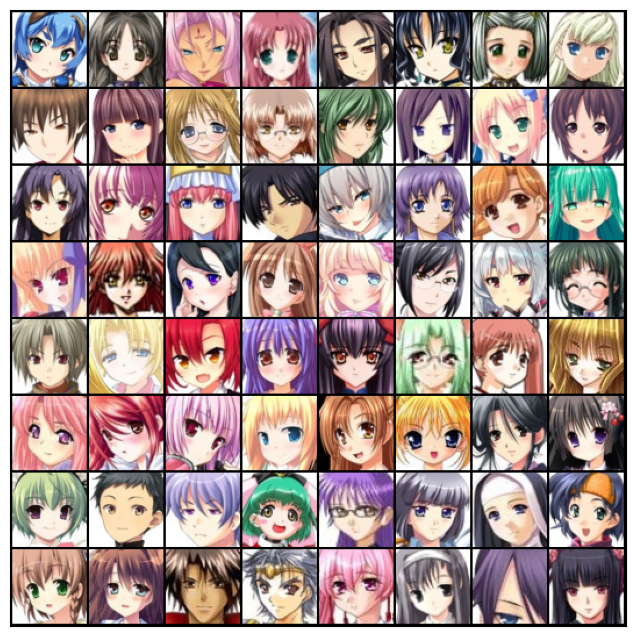

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')  # Return a CUDA device if available
    else:
        return torch.device('cpu')  # Return a CPU device if no CUDA device is available

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        # Recursively move each element of the list or tuple to the specified device
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)  # Move the tensor to the specified device

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)  # Yield a batch of data after moving it to the specified device

    def __len__(self):
        """Number of batches"""
        return len(self.dl)  # Return the number of batches in the wrapped dataloader


In [14]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [15]:
# Define the discriminator neural network architecture
discriminator = nn.Sequential(
    # Convolutional layer 1: Input channels (3 for RGB), output channels (64), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 64 channels, 32 x 32 spatial dimensions

    # Convolutional layer 2: Input channels (64), output channels (128), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 128 channels, 16 x 16 spatial dimensions

    # Convolutional layer 3: Input channels (128), output channels (256), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 256 channels, 8 x 8 spatial dimensions

    # Convolutional layer 4: Input channels (256), output channels (512), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 512 channels, 4 x 4 spatial dimensions

    # Convolutional layer 5: Input channels (512), output channels (1), kernel size (4x4),
    # stride (1), no padding, no bias term, followed by flattening and Sigmoid activation
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # Output: 1 channel, 1 x 1 spatial dimensions

    # Flatten the output tensor to a 1D tensor
    nn.Flatten(),
    # Apply Sigmoid activation to the flattened tensor
    nn.Sigmoid()
)


In [16]:
discriminator = to_device(discriminator, device)

In [17]:
import torch.nn as nn

# Define the size of the latent vector
latent_size = 128

# Define the generator neural network architecture
generator = nn.Sequential(
    # Transposed convolutional layer 1: Input channels (latent_size), output channels (512),
    # kernel size (4x4), stride (1), no padding, no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Output: 512 channels, 4 x 4 spatial dimensions

    # Transposed convolutional layer 2: Input channels (512), output channels (256),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Output: 256 channels, 8 x 8 spatial dimensions

    # Transposed convolutional layer 3: Input channels (256), output channels (128),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Output: 128 channels, 16 x 16 spatial dimensions

    # Transposed convolutional layer 4: Input channels (128), output channels (64),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Output: 64 channels, 32 x 32 spatial dimensions

    # Transposed convolutional layer 5: Input channels (64), output channels (3),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by Tanh activation (to ensure output values are in the range [-1, 1])
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # Output: 3 channels (RGB), 64 x 64 spatial dimensions
)


In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)  # Forward pass for real images
    real_targets = torch.ones(real_images.size(0), 1, device=device)  # Real labels
    real_loss = F.binary_cross_entropy(real_preds, real_targets)  # Binary cross-entropy loss
    real_score = torch.mean(real_preds).item()  # Mean prediction score for real images

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Generate random latent vectors
    fake_images = generator(latent)  # Generate fake images using the generator

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  # Fake labels
    fake_preds = discriminator(fake_images)  # Forward pass for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  # Binary cross-entropy loss
    fake_score = torch.mean(fake_preds).item()  # Mean prediction score for fake images

    # Update discriminator weights
    loss = real_loss + fake_loss  # Total loss for the discriminator
    loss.backward()  # Backpropagation
    opt_d.step()  # Update discriminator weights
    return loss.item(), real_score, fake_score


In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Generate random latent vectors
    fake_images = generator(latent)  # Generate fake images using the generator

    # Try to fool the discriminator
    preds = discriminator(fake_images)  # Forward pass for fake images through the discriminator
    targets = torch.ones(batch_size, 1, device=device)  # Target labels (ones)
    loss = F.binary_cross_entropy(preds, targets)  # Binary cross-entropy loss

    # Update generator weights
    loss.backward()  # Backpropagation
    opt_g.step()  # Update generator weights

    return loss.item()  # Return the loss value as a scalar


Saving generated-images-0000.png


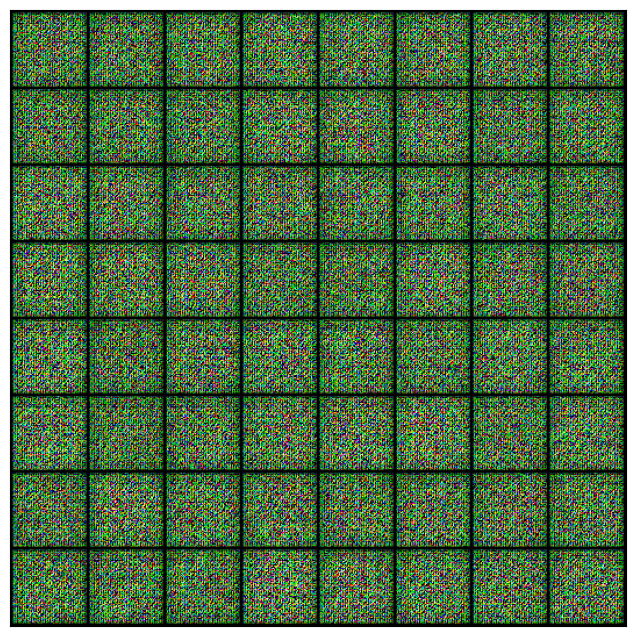

In [21]:
from torchvision.utils import save_image

# Specify the directory for saving generated samples
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    # Generate fake images using the generator
    fake_images = generator(latent_tensors)

    # Create a filename for the saved image
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    # Save the generated images to the specified directory
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

    # Optionally display the generated images
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        # Display the generated images in a grid using matplotlib
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# Generate fixed latent vectors for consistent sample generation
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# Save and optionally display generated samples using the fixed latent vectors
save_samples(0, fixed_latent)


In [22]:
from tqdm import tqdm
def fit(epochs, lr, start_idx=1):
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Lists to store losses and scores during training
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers for the discriminator and generator
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Training loop
    for epoch in range(epochs):
        # Iterate over batches in the training DataLoader
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores for the epoch
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores for the last batch of the epoch
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images for the epoch
        save_samples(epoch+start_idx, fixed_latent, show=False)

    # Return the recorded losses and scores
    return losses_g, losses_d, real_scores, fake_scores


In [23]:
lr = 0.0002
epochs = 10
history = fit(epochs, lr)

100%|██████████| 497/497 [02:06<00:00,  3.93it/s]


Epoch [1/10], loss_g: 3.2787, loss_d: 0.3473, real_score: 0.9073, fake_score: 0.1821
Saving generated-images-0001.png


100%|██████████| 497/497 [02:11<00:00,  3.77it/s]


Epoch [2/10], loss_g: 9.3684, loss_d: 0.3886, real_score: 0.7316, fake_score: 0.0014
Saving generated-images-0002.png


100%|██████████| 497/497 [02:11<00:00,  3.77it/s]


Epoch [3/10], loss_g: 4.5773, loss_d: 0.3864, real_score: 0.8154, fake_score: 0.1218
Saving generated-images-0003.png


100%|██████████| 497/497 [02:11<00:00,  3.78it/s]


Epoch [4/10], loss_g: 7.3734, loss_d: 0.7016, real_score: 0.5855, fake_score: 0.0001
Saving generated-images-0004.png


100%|██████████| 497/497 [02:11<00:00,  3.77it/s]


Epoch [5/10], loss_g: 6.0376, loss_d: 0.1841, real_score: 0.9941, fake_score: 0.1535
Saving generated-images-0005.png


100%|██████████| 497/497 [02:11<00:00,  3.77it/s]


Epoch [6/10], loss_g: 9.4639, loss_d: 0.1132, real_score: 0.9134, fake_score: 0.0001
Saving generated-images-0006.png


100%|██████████| 497/497 [02:11<00:00,  3.77it/s]


Epoch [7/10], loss_g: 4.8641, loss_d: 0.0395, real_score: 0.9912, fake_score: 0.0286
Saving generated-images-0007.png


100%|██████████| 497/497 [02:11<00:00,  3.78it/s]


Epoch [8/10], loss_g: 11.0060, loss_d: 0.2257, real_score: 0.9887, fake_score: 0.1507
Saving generated-images-0008.png


100%|██████████| 497/497 [02:11<00:00,  3.78it/s]


Epoch [9/10], loss_g: 6.1647, loss_d: 0.0363, real_score: 0.9766, fake_score: 0.0073
Saving generated-images-0009.png


100%|██████████| 497/497 [02:11<00:00,  3.77it/s]

Epoch [10/10], loss_g: 4.0312, loss_d: 0.2567, real_score: 0.8484, fake_score: 0.0085
Saving generated-images-0010.png


In [24]:
losses_g, losses_d, real_scores, fake_scores = history

In [25]:
# Save the trained generator model's state dictionary to a file
torch.save(generator.state_dict(), 'G.pth')

# Save the trained discriminator model's state dictionary to a file
torch.save(discriminator.state_dict(), 'D.pth')


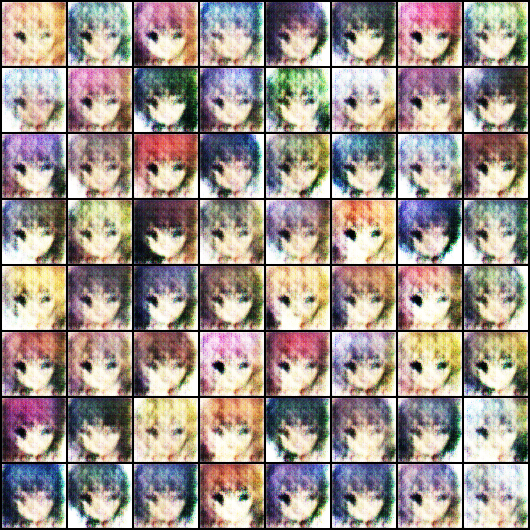

In [26]:
from IPython.display import Image
Image('./generated/generated-images-0001.png')

## Lab 4

### Use tensorflow/keras/pytorch to implement GANs on Fashion MNIST dataset. The Fashion MNIST Dataset is available under keras.datasets.

**1.Dataset Preparation**


In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Setting random seeds for reproducibility
tf.random.set_seed(123)
np.random.seed(123)

# Function to load and preprocess the Fashion MNIST dataset
def preprocess_fashion_mnist():
    (train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    train_images = train_images.astype('float32')
    train_images = (train_images - 127.5) / 127.5  # Scale to [-1, 1]
    train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension
    return train_images

fashion_mnist_data = preprocess_fashion_mnist()
print(f"Data Shape: {fashion_mnist_data.shape}")


Data Shape: (60000, 28, 28, 1)


**2.Generator Model**

In [58]:
def create_generator():
    latent_dim = 128  # Dimension of the latent (random) vector
    generator_model = models.Sequential([
        # Dense layer to reshape the latent vector into a 7x7x256 tensor
        layers.Dense(7 * 7 * 256, input_shape=(latent_dim,), use_bias=False),
        layers.BatchNormalization(),  # Normalize the outputs to help with training stability
        layers.LeakyReLU(0.2),  # Use LeakyReLU activation to introduce non-linearity

        # Reshape the 7x7x256 tensor into a 7x7x256 image
        layers.Reshape((7, 7, 256)),

        # First transposed convolutional layer to upscale the image to 7x7x128
        layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),  # Normalize the output of the convolution
        layers.LeakyReLU(0.2),  # LeakyReLU activation to introduce non-linearity

        # Second transposed convolutional layer to upscale the image to 14x14x64
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),  # Normalize the output of the convolution
        layers.LeakyReLU(0.2),  # LeakyReLU activation to introduce non-linearity

        # Final transposed convolutional layer to upscale the image to 28x28x1 (grayscale)
        layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return generator_model

generator = create_generator()
generator.summary()  # Displaying the summary of the model to see the architecture


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 12544)               │       1,605,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_55 (LeakyReLU)           │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_11 (Reshape)                 │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_30                  │ (None, 7, 7, 128)           │         524,288 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_56 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_31                  │ (None, 14, 14, 64)          │         131,072 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_57 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_32                  │ (None, 28, 28, 1)           │           1,024 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,312,960 (8.82 MB)

 Trainable params: 2,287,488 (8.73 MB)

 Non-trainable params: 25,472 (99.50 KB)

**3.Discriminator Model**

In [59]:
def create_discriminator():
    discriminator_model = models.Sequential([
        # First convolutional layer to detect low-level features from the image
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(0.2),  # LeakyReLU activation to allow for negative values
        layers.Dropout(0.3),  # Dropout regularization to prevent overfitting

        # Second convolutional layer to detect more complex features
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),  # LeakyReLU activation
        layers.Dropout(0.3),  # Dropout regularization

        # Flatten the feature map into a 1D vector to pass into a dense layer
        layers.Flatten(),

        # Dense layer with a sigmoid activation to output a probability (real or fake)
        layers.Dense(1, activation='sigmoid')
    ])
    return discriminator_model

discriminator = create_discriminator()
discriminator.summary()  # Displaying the summary of the model to see the architecture


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 14, 14, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_58 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_59 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,561 (541.25 KB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

**4.Loss Functions and GAN Class Definition**

In [60]:
# Loss function for Binary Cross-Entropy, used to measure the difference between real and predicted values
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Function to calculate the discriminator loss
def discriminator_loss(real_output, fake_output):
    # Real images should be classified as 1 (real)
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    # Fake images should be classified as 0 (fake)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    # Total loss is the sum of both real and fake losses
    return real_loss + fake_loss

# Function to calculate the generator loss
def generator_loss(fake_output):
    # Generator aims to trick the discriminator into classifying fake images as real (1)
    return binary_cross_entropy(tf.ones_like(fake_output), fake_output)

# GAN Class definition for FashionGAN
class FashionGAN:
    def __init__(self, noise_dim=128):
        # Initialize the GAN model with default noise dimension and batch size
        self.noise_dim = noise_dim
        self.batch_size = 128

        # Create the generator and discriminator models
        self.generator = create_generator()
        self.discriminator = create_discriminator()

        # Initialize Adam optimizers for both the generator and the discriminator
        self.gen_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.disc_optimizer = tf.keras.optimizers.Adam(1e-4)

    # Defining the training step, decorated as a TensorFlow function for performance
    @tf.function
    def train_step(self, images):
        # Generate random noise for the generator input
        noise = tf.random.normal([self.batch_size, self.noise_dim])

        # Use GradientTape to record the computation of the gradients during training
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake images using the generator
            fake_images = self.generator(noise, training=True)

            # Get discriminator's output for both real and fake images
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            # Compute the losses for the generator and discriminator
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        # Compute the gradients of the loss with respect to the model's trainable variables
        gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        # Applying the computed gradients to update the model parameters
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        # Return the generator and discriminator losses
        return gen_loss, disc_loss


**5.Training Loop**

In [61]:
# Function to train the GAN model for a specified number of epochs
def train_gan(fashion_gan, dataset, num_epochs):
    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize lists to store average generator and discriminator losses
        gen_loss_avg = []
        disc_loss_avg = []

        # Iterate over the dataset in batches
        for real_images in dataset:
            # Perform a training step (forward pass and backpropagation) and get losses
            g_loss, d_loss = fashion_gan.train_step(real_images)
            # Append the losses to the respective lists
            gen_loss_avg.append(g_loss)
            disc_loss_avg.append(d_loss)

        # Print the average losses for this epoch
        print(f"Epoch {epoch + 1}, Generator Loss: {np.mean(gen_loss_avg):.4f}, Discriminator Loss: {np.mean(disc_loss_avg):.4f}")

# Function to visualize generated images after training
def plot_generated_images(generator, noise_dim=128, num_images=16):
    # Generate random noise for the generator
    noise = tf.random.normal([num_images, noise_dim])
    # Use the generator to create fake images from the noise
    fake_images = generator(noise, training=False)

    # Set up the plot to display the generated images in a grid
    plt.figure(figsize=(4, 4))
    # Iterate through the generated images and display each one
    for i in range(num_images):
        # Place each image in the subplot grid
        plt.subplot(4, 4, i + 1)
        # Scale the pixel values to [0, 255] and display in grayscale
        plt.imshow(fake_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')  # Hide axes for clarity
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()  # Display the plot with generated images


**6.Training and Displaying Results**

Epoch 1, Generator Loss: 0.7936, Discriminator Loss: 1.2049
Epoch 2, Generator Loss: 0.8682, Discriminator Loss: 1.2364
Epoch 3, Generator Loss: 0.7675, Discriminator Loss: 1.3424
Epoch 4, Generator Loss: 0.7493, Discriminator Loss: 1.3419
Epoch 5, Generator Loss: 0.8421, Discriminator Loss: 1.2903
Epoch 6, Generator Loss: 0.8363, Discriminator Loss: 1.2494
Epoch 7, Generator Loss: 0.9061, Discriminator Loss: 1.2139
Epoch 8, Generator Loss: 1.0148, Discriminator Loss: 1.0944
Epoch 9, Generator Loss: 1.0460, Discriminator Loss: 1.0798
Epoch 10, Generator Loss: 1.1578, Discriminator Loss: 1.0055
Epoch 11, Generator Loss: 1.2122, Discriminator Loss: 0.9547
Epoch 12, Generator Loss: 1.3332, Discriminator Loss: 0.9119
Epoch 13, Generator Loss: 1.3565, Discriminator Loss: 0.9017
Epoch 14, Generator Loss: 1.3463, Discriminator Loss: 0.9113
Epoch 15, Generator Loss: 1.3552, Discriminator Loss: 0.9148
Epoch 16, Generator Loss: 1.4124, Discriminator Loss: 0.9209
Epoch 17, Generator Loss: 1.5172,

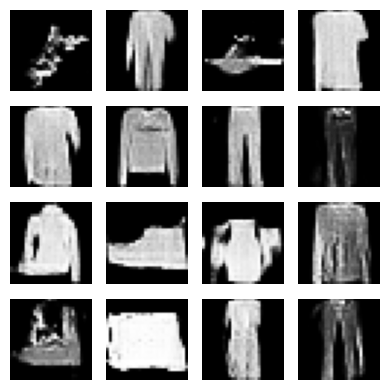

In [62]:
# Main function to execute the GAN pipeline
def main():
    # Prepare the dataset by shuffling and batching the Fashion MNIST data
    train_data = tf.data.Dataset.from_tensor_slices(fashion_mnist_data).shuffle(60000).batch(128)

    # Initialize the GAN model by creating an instance of the FashionGAN class
    gan_model = FashionGAN()

    # Train the GAN model for 50 epochs using the training dataset
    train_gan(gan_model, train_data, num_epochs=50)

    # After training, visualize the generated images from the generator
    plot_generated_images(gan_model.generator)

# This ensures that the main function is executed when the script is run
if __name__ == "__main__":
    main()

